In [9]:
# Load Prediction with Arima

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib.dates import DateFormatter

In [6]:
load_data = pd.read_csv("miris_load.csv", parse_dates=['DateTime'], index_col= ['DateTime'])
weather_data = pd.read_csv('weather_data.csv', parse_dates=['Time'], index_col= ['Time'])

In [7]:
load_data.index = pd.to_datetime(load_data.index)
weather_data.index = pd.to_datetime(weather_data.index)

In [8]:
print(load_data.columns)
load_data = load_data.reset_index()
load_data.set_index('DateTime', inplace=True)
load_df = load_data.resample('15T').mean()

Index(['Conso'], dtype='object')


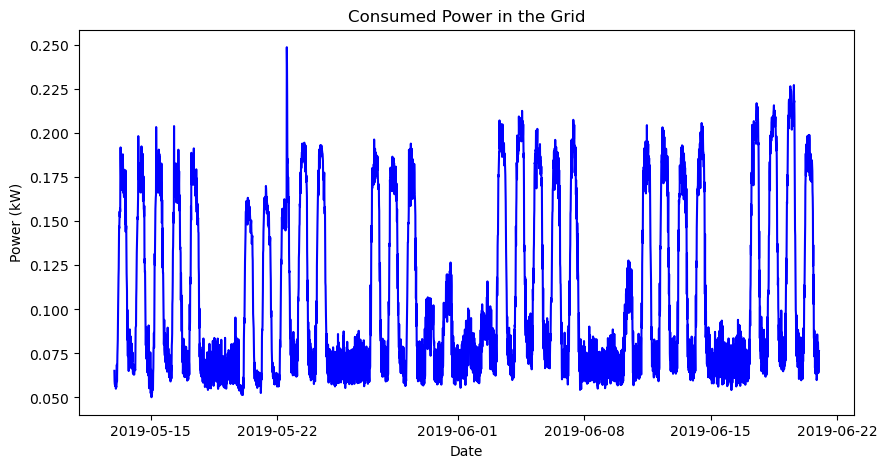

In [10]:
# Plotting PV generation data
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=load_df, x=load_df.index, y="Conso", ax=ax, color='blue')
ax.set_title("Consumed Power in the Grid")
ax.set_xlabel("Date")
ax.set_ylabel("Power (kW)")
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.show()

In [30]:
# filter two datasets to get the same time line

weather_filtered = weather_data.loc['2019-05-14T00:00:00+02:00':'2019-06-18T00:00:00+02:00']
load_filtered = load_df.loc['2019-05-14T00:00:00+02:00':'2019-06-18T00:00:00+02:00']

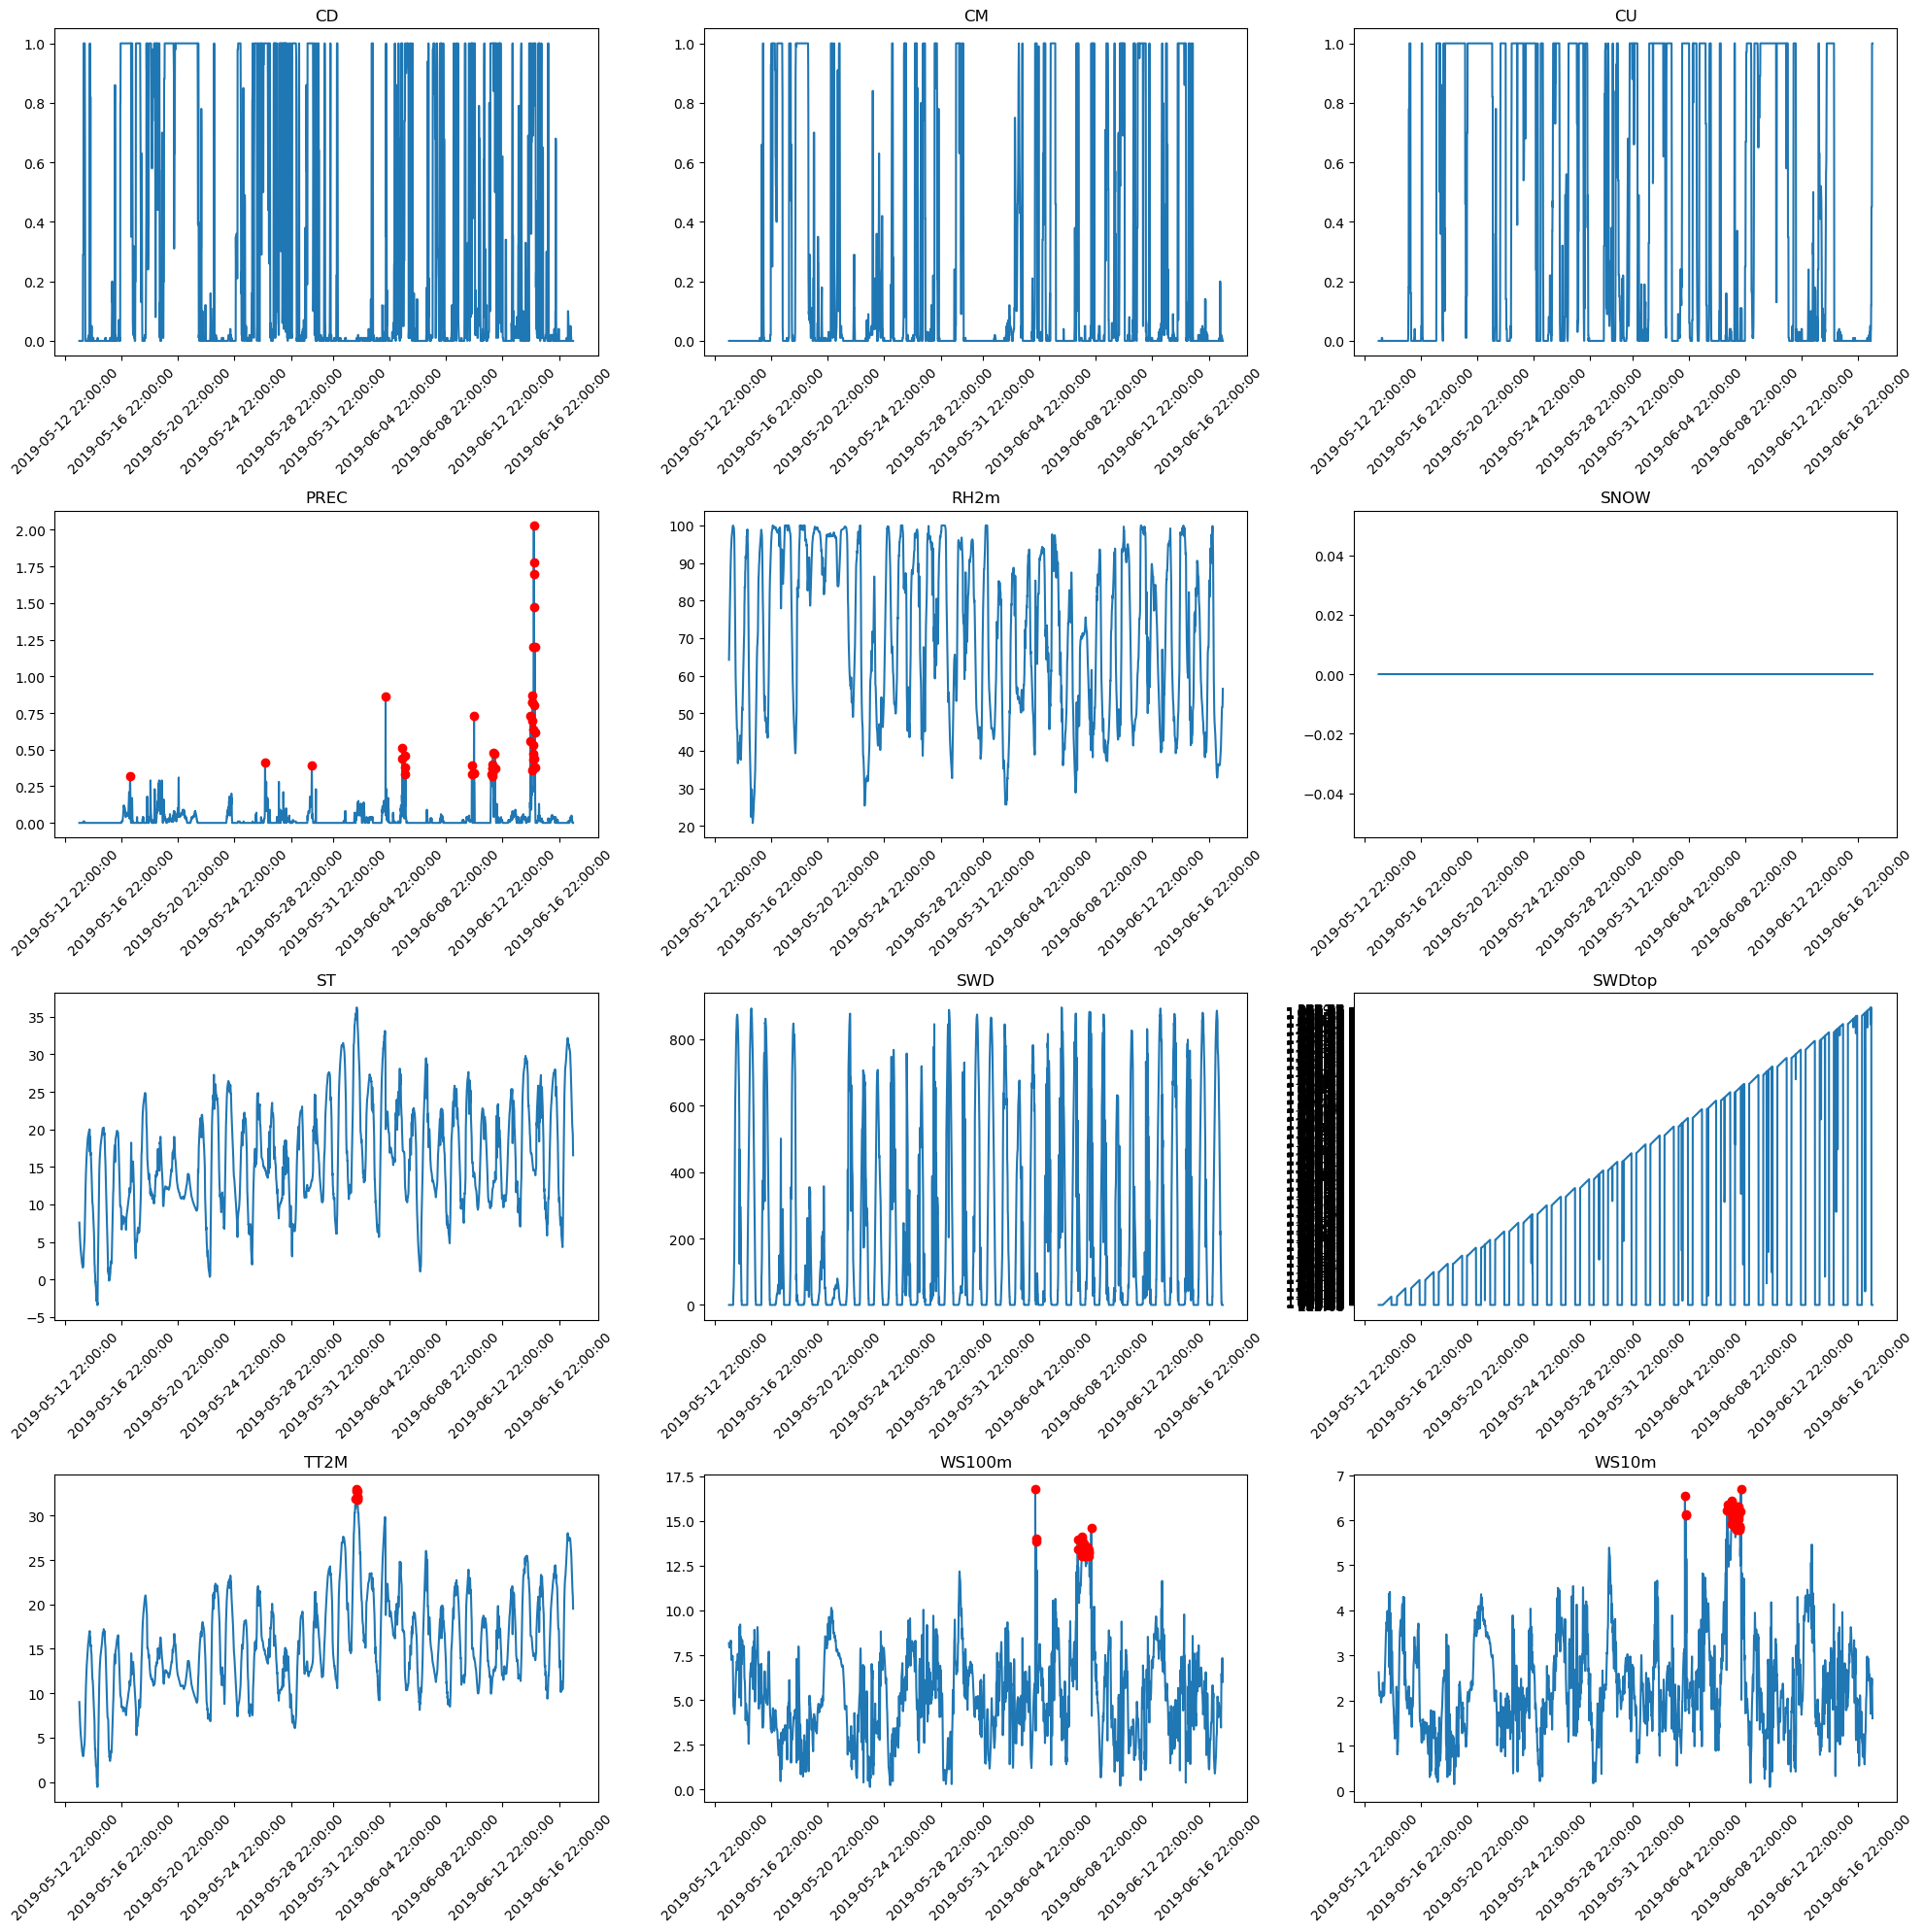

In [16]:
# Define the number of standard deviations from the mean that will be considered anomalous
num_std_devs = 3

# Calculate the z-score for each column in the weather data
z_scores = (weather_filtered - weather_filtered.mean()) / weather_filtered.std()

# Identify any values that are more than num_std_devs standard deviations from the mean
anomaly_mask = (z_scores.abs() > num_std_devs)

# Create a grid of subplots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))

# Iterate over each weather feature and plot the data
for i, col in enumerate(weather_filtered.columns):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    ax.plot(weather_filtered.index, weather_filtered.iloc[:, i])
    if anomaly_mask.iloc[:, i].any():
        ax.plot(weather_filtered.index[anomaly_mask.iloc[:, i]], weather_filtered.iloc[:, i][anomaly_mask.iloc[:, i]], 'ro')
    ax.set_title(weather_filtered.columns[i])
    date_form = DateFormatter('%Y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(date_form)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [17]:
merged_df = pd.concat([load_filtered, weather_filtered], axis=1)
merged_df.index.name = 'datetime'
merged_df.reset_index(inplace=True)
merged_df['datetime'] = pd.to_datetime(merged_df['datetime'])
merged_df = merged_df.set_index('datetime')
merged_df = merged_df.asfreq('15T')
merged_df = merged_df.drop(['SNOW'], axis = 1)
merged_df = merged_df.replace('\u202f', ' ', regex=True)


merged_df['SWDtop'] = merged_df['SWDtop'].str.replace(' ', '').astype(float)



merged_df['Conso'].describe()
merged_df.shape

selected_features = ['SWDtop', 'SWD', 'RH2m']


<AxesSubplot:>

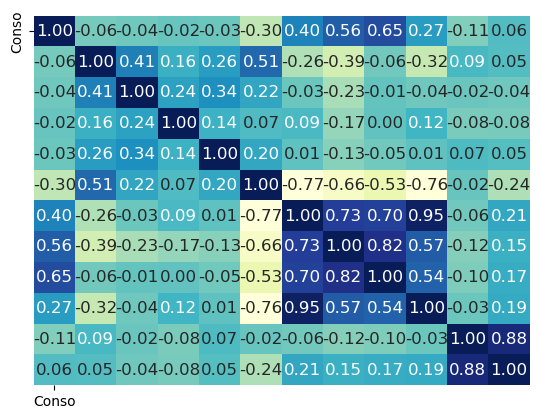

In [18]:
cor = merged_df.corr()
A= cor['Conso'].sort_values(ascending= False)
sns.heatmap(cor, cmap="YlGnBu", annot=True, annot_kws={"size": 12}, fmt=".2f", cbar=False, xticklabels=45, yticklabels=45)


In [19]:
train_data, test_data = train_test_split(merged_df, test_size=0.2, shuffle=False)

#train_data.select_dtypes(exclude='number')
#print(train_data['SWDtop'].dtype)
print(np.isfinite(train_data).all())
print(np.isfinite(test_data).all())
test_data.shape
np.log(train_data['Conso'])

train_data[selected_features]

Conso     True
CD        True
CM        True
CU        True
PREC      True
RH2m      True
ST        True
SWD       True
SWDtop    True
TT2M      True
WS100m    True
WS10m     True
dtype: bool
Conso     True
CD        True
CM        True
CU        True
PREC      True
RH2m      True
ST        True
SWD       True
SWDtop    True
TT2M      True
WS100m    True
WS10m     True
dtype: bool


,SWDtop,SWD,RH2m
datetime,,,
2019-05-13 22:00:00+00:00,0.0,0.0,64.23
2019-05-13 22:15:00+00:00,0.0,0.0,66.35
2019-05-13 22:30:00+00:00,0.0,0.0,68.59
2019-05-13 22:45:00+00:00,0.0,0.0,70.89
2019-05-13 23:00:00+00:00,0.0,0.0,73.26
...,...,...,...
2019-06-10 20:45:00+00:00,0.0,0.0,95.50
2019-06-10 21:00:00+00:00,0.0,0.0,95.71
2019-06-10 21:15:00+00:00,0.0,0.0,97.75


In [20]:
#alpha = np.log(train_data['Conso'])
model = ARIMA(train_data['Conso'], order=(4, 0, 4), exog=train_data.loc[:, selected_features])
model_fit = model.fit()

In [21]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Conso   No. Observations:                 2688
Model:                 ARIMA(4, 0, 4)   Log Likelihood                8549.327
Date:                Thu, 23 Mar 2023   AIC                         -17072.653
Time:                        09:07:17   BIC                         -16995.998
Sample:                    05-13-2019   HQIC                        -17044.926
                         - 06-10-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0526      0.008      6.333      0.000       0.036       0.069
SWDtop      5.822e-05   4.07e-06     14.305      0.000    5.02e-05    6.62e-05
SWD        -2.334e-06   2.17e-06     -1.076      0.2

In [22]:
predictions_train = model_fit.forecast(len(train_data), exog=train_data.loc[:, selected_features], alpha=0.05)
predictions_test = model_fit.forecast(len(test_data), exog=test_data.loc[:, selected_features], alpha=0.05)

# Convert the predictions to a pandas series and set the index to match the original data
#predictions_train = pd.Series(predictions_train, index=train_data.index)
#predictions_test = pd.Series(predictions_test, index=test_data.index)
#predictions_test

predictions_test

2019-06-10 22:00:00+00:00    0.067407
2019-06-10 22:15:00+00:00    0.065373
2019-06-10 22:30:00+00:00    0.065152
2019-06-10 22:45:00+00:00    0.066308
2019-06-10 23:00:00+00:00    0.066774
                               ...   
2019-06-17 21:00:00+00:00    0.063559
2019-06-17 21:15:00+00:00    0.063559
2019-06-17 21:30:00+00:00    0.063601
2019-06-17 21:45:00+00:00    0.063950
2019-06-17 22:00:00+00:00    0.064606
Freq: 15T, Name: predicted_mean, Length: 673, dtype: float64

In [23]:
mae_test = mean_absolute_percentage_error(test_data['Conso'], predictions_test)
rmse_test = mean_squared_error(test_data['Conso'], predictions_test, squared=False)

print("MAE_test:", mae_test)
print("RMSE_test:", rmse_test)

MAE_test: 0.2696840683072065
RMSE_test: 0.04215490281930255


In [24]:
mae_train = mean_absolute_percentage_error(train_data['Conso'], predictions_train)
rmse_train = mean_squared_error(train_data['Conso'], predictions_train, squared=False)

print("MAE_train:", mae_train)
print("RMSE_train:", rmse_train)

MAE_train: 0.2707906076053112
RMSE_train: 0.03673600635818388


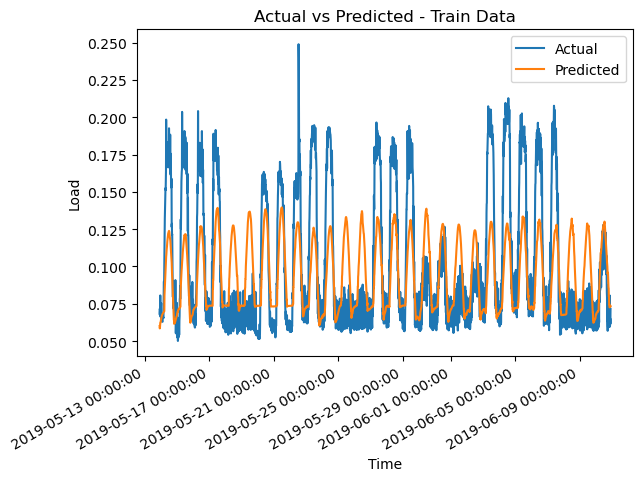

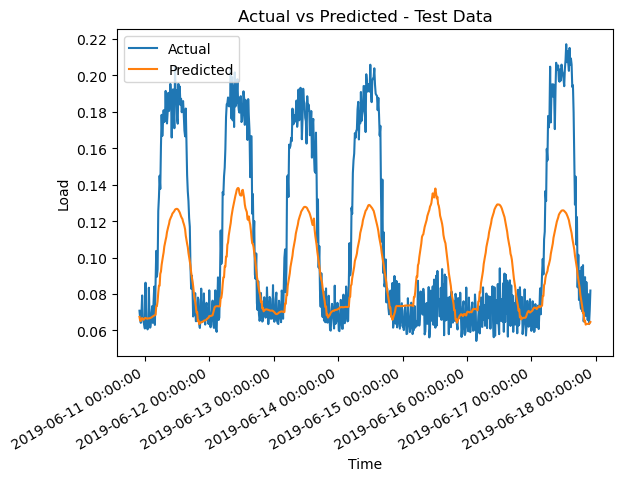

In [29]:
fig, ax = plt.subplots()
ax.plot(train_data.index, train_data['Conso'], label='Actual')
ax.plot(train_data.index, predictions_train, label='Predicted')
ax.set_title('Actual vs Predicted - Train Data')
ax.set_xlabel('Time')
ax.set_ylabel('Load')
ax.legend()

# Format the x-axis to display the time stamp
date_form = DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

plt.show()

# plot actual vs predicted values for test data
fig, ax = plt.subplots()
ax.plot(test_data.index, test_data['Conso'], label='Actual')
ax.plot(test_data.index, predictions_test, label='Predicted')
ax.set_title('Actual vs Predicted - Test Data')
ax.set_xlabel('Time')
ax.set_ylabel('Load')
ax.legend()

# Format the x-axis to display the time stamp
date_form = DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

plt.show()

In [26]:
# Calculate R-squared for train data
r2_train = r2_score(train_data['Conso'], predictions_train)

# Calculate R-squared for test data
r2_test = r2_score(test_data['Conso'], predictions_test)

print('R-squared for train data:', r2_train)
print('R-squared for test data:', r2_test)

R-squared for train data: 0.37183710887142585
R-squared for test data: 0.336917475473554


In [27]:
merged_df['Conso'].min()

0.05013885328518514